# Data Extraction

The aim of this notebook is to extract the data including the time series from MIMIC-III database.

## Setting up the platform

Before extracting data, MIMIC-III is installed in a local Postgres database on Windows. Tutorial on installing the database is available on [MIMIC-III offical website](https://mimic.physionet.org/tutorials/install-mimic-locally-windows/).

Since we will use the SAPS-II score as the benchmark on mortality perdiction. SAPS-II score can be calculated in MIMIC-III database. The code to create materialized view for SAPS-II score is available in [GitHub](https://github.com/MIT-LCP/mimic-code/tree/master/concepts/severityscores).

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import os

# for pretty printing pandas dataframes
from IPython.display import display, HTML

%matplotlib inline
plt.style.use('ggplot')

# information used to create a database connection, stored as params
# Please change to your postgres password, 'hydrogenoxygen' is the password in my local machine 
dbinfo = "user=postgres dbname=mimic password=hydrogenoxygen" 

Data extraction will begin with writing some functions which will be used in this notebook.

In [2]:
def execute_query(query, dbinfo, params=None):
    """ Execute the query on the local database. 
    
    Args:
        query (string): sql query
        dbinfo (string): connection strings, e.g, "user=postgres dbname=mimic password=hydrogenoxygen" 
        params (dictionary): parameters to SQL queries
        
    Returns:
        Pandas dataFrame or exception.
    """
    
    try:
        with psycopg2.connect(dbinfo) as con:
            # use pandas to read the query
            df = pd.read_sql_query(query, con, params=params)
            return df
    
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        
def get_path(filename, suffix):
    """Return the path
    
    Args: 
        filename (string): name of the file
        suffix (string): extension of the file
        
    Returns:
        path
    """
    # Join the path for "data" folder
    cwd = os.getcwd()
    dir_name = os.path.join(cwd, 'data')
    
    return os.path.join(dir_name, filename + "." + suffix)
        
def save_to_csv(df, path):
    """ Save the extracted dataframe into csv file under "data" folder.
    
    Args: 
        df (Pandas Dataframe): the dataframe needed to be saved
        filename (string): name of the file
        
    Returns:
        None
    """
    dir_name, filename = os.path.split(path)
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
     
    df.to_csv(path)
    

First we can dive in and obtain a list of all the tables in MIMIC-III. There should be 26 tables in the database under schema name "mimiciii" (https://mimic.physionet.org/).

In [7]:
query = """select * from pg_tables where schemaname='mimiciii' and hasindexes"""

# get the tables
tables = execute_query(query, dbinfo)

print("Shape of table:", tables.shape, "\n")

print("The top 5 rows of the table are:")
tables.head()

Shape of table: (26, 8) 

The top 5 rows of the table are:


,schemaname,tablename,tableowner,tablespace,hasindexes,hasrules,hastriggers,rowsecurity
0,mimiciii,d_items,postgres,None,True,False,False,False
1,mimiciii,d_labitems,postgres,None,True,False,False,False
2,mimiciii,icustays,postgres,None,True,False,False,False
3,mimiciii,admissions,postgres,None,True,False,False,False
4,mimiciii,callout,postgres,None,True,False,False,False


Since we focus on the tables under scheman name "mimiciii", we set a search path for convenience.

In [8]:
# schema name for setting a search path
schema_name = 'mimiciii'
query_schema = 'set search_path to ' + schema_name + ';'

## Cohort selection

Cohort selection is based on three tables: *patients*, *admissions*, and *icustays*.

* *patients*: information about a patient that does not change - e.g. date of birth, genotypical sex
* *admissions*: information recorded on hospital admission - admission type (elective, emergency), time of admission
* *icustays*: information recorded on intensive care unit admission - primarily admission and discharge time

The data we considered when these conditions are true:
* Patients are older than 16 years old
* Length of ICU stay is longer than 1 day but less than 10 days
* The first ICU admission during ICU stay
* The unexpected medicial events
* Admissions with chart data

In [9]:
# parameters will pass to sql query
cohort_params = {'year': 60.0*60.0*24.0*365.242, 'minage': 16, 'minstay': 1, 'maxstay': 10}

cohort_query = query_schema + """
WITH t0 AS
(
    SELECT icu.subject_id, icu.hadm_id, icu.icustay_id
    , round(cast(extract('epoch' from icu.intime - pat.dob)/%(year)s as numeric),2) AS age          -- calculate the age 
    , round(cast(icu.los as numeric),2) as los
    , RANK() OVER (PARTITION BY icu.subject_id ORDER BY icu.intime) AS icustay_order                -- rank the ICU admission
    , CASE                                                                                          -- Age < 16 --> 0
        WHEN round(cast(extract('epoch' from icu.intime - pat.dob)/%(year)s as numeric),2) < %(minage)s THEN 1 
        ELSE 0 END AS excl_age                                                                      
    , CASE                                                                                          -- 1 <=Length <= 10 --> 0
        WHEN (icu.los BETWEEN %(minstay)s AND %(maxstay)s) THEN 0 ELSE 1 END AS excl_los            
    , CASE                                                                                          -- first ICU admission --> 0
        WHEN RANK() OVER (PARTITION BY icu.subject_id ORDER BY icu.intime) != 1 THEN 1              
        ELSE 0 END AS excl_icustay
    FROM icustays icu INNER JOIN patients pat ON icu.subject_id = pat.subject_id
)
, t1 AS
(
    SELECT adm.admission_type, adm.hadm_id, adm.has_chartevents_data
    , CASE                                                                                          -- exclude NEWBORN/ELECTIVE cases 
        WHEN admission_type IN ('EMERGENCY', 'URGENT') THEN 0                                       
        ELSE 1 END AS excl_plan
    , CASE
        WHEN adm.has_chartevents_data = 1 then 0 else 1 end as excl_chartevents
    FROM admissions as adm
)
SELECT
-- attributes
t0.subject_id, t0.hadm_id, t0.icustay_id, t0.age, t0.los, 
t1.admission_type, t1.has_chartevents_data,

-- exclusions
t0.icustay_order, t0.excl_age, t0.excl_los, t0.excl_icustay, 
t1.excl_plan, t1.excl_chartevents

FROM t0 INNER JOIN t1 ON t0.hadm_id = t1.hadm_id 
"""
#icustay_id is the primary key in cohort table
cohort_table = execute_query(cohort_query, dbinfo, params=cohort_params)
print("dimensions of cohort table:", cohort_table.shape)
cohort_table.head()


dimensions of cohort table: (61532, 13)


,subject_id,hadm_id,icustay_id,age,los,admission_type,has_chartevents_data,icustay_order,excl_age,excl_los,excl_icustay,excl_plan,excl_chartevents
0,58526,100001,275225,35.48,4.26,EMERGENCY,1,1,0,0,0,0,0
1,54610,100003,209281,59.91,1.94,EMERGENCY,1,1,0,0,0,0,0
2,9895,100006,291788,48.92,4.98,EMERGENCY,1,1,0,0,0,0,0
3,23018,100007,217937,73.82,4.10,EMERGENCY,1,1,0,0,0,0,0
4,533,100009,253656,60.80,2.49,EMERGENCY,1,1,0,0,0,0,0


Since all exclusions are listed in the table, the exclusion criteria are clearly stated. We summarize the cohort selection by tabularing the statistics.

In [10]:
print( '{:25s} {:5s}'.format('Condition:', 'value(%)') )

print( '{:25s} {:5d} ({:2.2f}%)'.format('Total observations', cohort_table.shape[0], 100))

# create a boolean list with df.shape[0]
idxExcl = np.zeros(cohort_table.shape[0],dtype=bool) 

# calucate the exclusion percentage for each condition
for col in cohort_table.columns:
    if "excl_" in col:
        print('{:25s} {:5d} ({:2.2f}%)'.format(col, cohort_table[col].sum(), cohort_table[col].sum()*100.0/cohort_table.shape[0]))
        idxExcl = (idxExcl) | (cohort_table[col]==1) # bitwise or
        
# print a summary of how many were excluded in total
print('')
print('{:25s} {:5d} ({:2.2f}%)'.format('Total excluded', np.sum(idxExcl), np.sum(idxExcl)*100.0/cohort_table.shape[0]))
print('{:25s} {:5d} ({:2.2f}%)'.format('Total included', cohort_table.shape[0] - np.sum(idxExcl), 
                                       100 - np.sum(idxExcl)*100.0/cohort_table.shape[0]))

Condition:                value(%)
Total observations        61532 (100.00%)
excl_age                   8109 (13.18%)
excl_los                  19089 (31.02%)
excl_icustay              15056 (24.47%)
excl_plan                 15331 (24.92%)
excl_chartevents            481 (0.78%)

Total excluded            37495 (60.94%)
Total included            24037 (39.06%)


In total, about 61% of the patients are excluded due to the reasons we mentioned. We now can obtain ICU stay IDs of the cohort, which will be used for data exploration and analysis.

In [11]:
conditions = (cohort_table['excl_age']==0) & (cohort_table['excl_los']==0) \
                 & (cohort_table['excl_icustay']==0) & (cohort_table['excl_plan']==0) \
                 & (cohort_table['excl_chartevents']==0)
        
cohort = cohort_table[conditions]
cohortIDs = tuple([np.asscalar(x) for x in cohort['icustay_id']]) # cast to integer
print( 'Total observations in cohort:', cohort.shape[0])
cohort.head()

Total observations in cohort: 24037


,subject_id,hadm_id,icustay_id,age,los,admission_type,has_chartevents_data,icustay_order,excl_age,excl_los,excl_icustay,excl_plan,excl_chartevents
0,58526,100001,275225,35.48,4.26,EMERGENCY,1,1,0,0,0,0,0
1,54610,100003,209281,59.91,1.94,EMERGENCY,1,1,0,0,0,0,0
2,9895,100006,291788,48.92,4.98,EMERGENCY,1,1,0,0,0,0,0
3,23018,100007,217937,73.82,4.10,EMERGENCY,1,1,0,0,0,0,0
4,533,100009,253656,60.80,2.49,EMERGENCY,1,1,0,0,0,0,0


## Demographics of cohort

The patients' general details can be extracted from tables: *patients* and *icustays*. Gender, age, intime, outtime, lonegth of stay, and survival are considered. 

In [12]:
params = {'year': 60.0*60.0*24.0*365.242, 'day': 60.0*60.0*24.0, 'cohortIDs':cohortIDs}

query = query_schema + """
SELECT icu.subject_id, icu.hadm_id, icu.icustay_id, pat.gender, icu.dbsource
, ROUND(CAST(EXTRACT(epoch FROM icu.intime - pat.dob)/%(year)s AS numeric),2) AS age
, icu.intime
, round(cast(extract(epoch from adm.dischtime - icu.intime)/%(day)s as numeric), 2) as los
, case 
    when (pat.dod is not null) 
    then round(cast(extract(epoch from pat.dod - icu.intime)/%(day)s as numeric), 2) 
    else -1 end as survival
, case 
    when round(cast(extract(epoch from adm.dischtime - icu.intime)/%(day)s as numeric), 2)
         >= round(cast(extract(epoch from pat.dod - icu.intime)/%(day)s as numeric), 2) 
    then 1 else 0 end as in_hospital_dealth
FROM icustays icu
INNER JOIN patients pat ON icu.subject_id = pat.subject_id
INNER JOIN admissions adm on adm.hadm_id = icu.hadm_id
WHERE icu.icustay_id in %(cohortIDs)s
ORDER BY icu.subject_id, icu.intime;
"""
patient_details = execute_query(query, dbinfo, params=params)
patient_details.head()

,subject_id,hadm_id,icustay_id,gender,dbsource,age,intime,los,survival,in_hospital_dealth
0,3,145834,211552,M,carevue,76.53,2101-10-20 19:10:11,10.78,236.20,0
1,4,185777,294638,F,carevue,47.85,2191-03-16 00:29:31,7.76,-1.00,0
2,9,150750,220597,M,carevue,41.79,2149-11-09 13:07:02,4.88,4.45,1
3,11,194540,229441,F,carevue,50.15,2178-04-16 06:19:32,25.53,211.74,0
4,13,143045,263738,F,carevue,39.87,2167-01-08 18:44:25,6.85,-1.00,0


To protect patient confidentiality, all dates in the database have been shifted. Furthermore, the patient's date of birth was shifted before the year 1900 if the patient is older than 89. In these cases, the patient's age at the first admission has been fixed to 300 years old. The median age for this group of patients is 91.4 (https://mimic.physionet.org/mimictables/patients/). Therefore, the age of patients who are older than 89 years old is replaced by the median, which is 91.4 years old. 

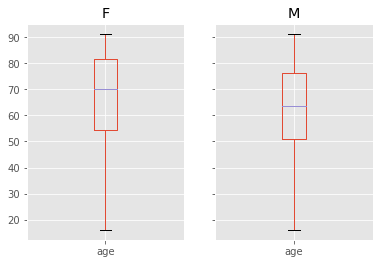

In [13]:
shifted_age = patient_details['age'] >= 300
patient_details.loc[shifted_age, 'age'] = 91.4
age_bplot = patient_details[['gender','age']].groupby('gender').boxplot(return_type='axes')

In the following section, patients' average height and weight are extracted from tables: *charttime* and *icustay*. The SQL query is modified from the SQL query from the code in [GitHub](https://github.com/MIT-LCP/mimic-code/blob/master/concepts/demographics/HeightWeightQuery.sql).

In [14]:
query = query_schema + """
with rawdata as 
    ( -- data extraction, transformation, and cleaning
    SELECT c.charttime, c.itemid,c.subject_id, c.icustay_id,
    CASE
        WHEN c.itemid IN (762, 763, 3723, 3580, 3581, 3582, 226512) THEN 'WEIGHT'
        WHEN c.itemid IN (920, 1394, 4187, 3486, 3485, 4188, 226707) THEN 'HEIGHT'
    END AS category,
    -- Ensure that all weights are in kg and heights are in centimeters
    CASE
        WHEN c.itemid IN (3581, 226531) THEN c.valuenum * 0.45359237            -- lb to kg
        WHEN c.itemid IN (3582) THEN c.valuenum * 0.0283495231                  -- ounce to kg
        WHEN c.itemid IN (920, 1394, 4187, 3486, 226707) THEN c.valuenum * 2.54 -- in to cm
        ELSE c.valuenum
    END AS valuenum
    FROM chartevents c
        WHERE c.icustay_id in %(cohortIDs)s
              AND c.valuenum IS NOT NULL
              -- exclude rows marked as error
              AND c.error IS DISTINCT FROM 1 -- not 1
              AND c.itemid IN (-- Carevue
                                762, 763, 3723, 3580,                     -- Weight Kg
                                3581,                                     -- Weight lb
                                3582,                                     -- Weight oz
                                920, 1394, 4187, 3486,                    -- Height inches
                                3485, 4188,                               -- Height cm
                                -- Metavision
                                226707,                                   -- Height, cm
                                226512)                                   -- Admission Weight (Kg) 
              AND c.valuenum <> 0
    )
, singlefeature as 
    ( -- feature selection
    SELECT distinct subject_id, icustay_id, category,
    avg(valuenum) over
        (partition BY subject_id, icustay_id, category
         order by charttime ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS avg_valuenum
    FROM rawdata order by subject_id, icustay_id, category
    )
, pivotfeatures AS 
    (
    SELECT subject_id, icustay_id,
    MAX(case when category = 'HEIGHT' then avg_valuenum else NULL end) AS height_avg,
    MAX(case when category = 'WEIGHT' then avg_valuenum else NULL end) AS weight_avg
    FROM singlefeature GROUP BY subject_id, icustay_id
    )
    
SELECT f.icustay_id, f.subject_id,
ROUND(cast(f.height_avg as numeric),1) AS height_avg,
ROUND(cast(f.weight_avg as numeric),1) AS weight_avg
FROM pivotfeatures f ORDER BY subject_id, icustay_id;
"""
patient_weightheight = execute_query(query, dbinfo, params=params)
patient_weightheight.head()

,icustay_id,subject_id,height_avg,weight_avg
0,211552,3,179.1,101.9
1,294638,4,NaN,53.6
2,220597,9,182.9,102.9
3,263738,13,144.8,73.6
4,217847,21,175.3,65.3


Then, the patient weight and height relation is concatenated into the patient detail relation. The resulted relation is saved for future use.

In [17]:
# To concatenate patient_details and weighthieght tables 
cols_to_use = patient_weightheight.columns.difference(patient_details.columns)
patient_details = pd.concat([patient_details, patient_weightheight[cols_to_use]], axis=1)

# To save the dataframe
file_path = get_path('patient_details', 'csv')
save_to_csv(patient_details, file_path)

# Print the dataframe
patient_details.head()

,subject_id,hadm_id,icustay_id,gender,dbsource,age,intime,los,survival,in_hospital_dealth,height_avg,weight_avg
0,3,145834,211552,M,carevue,76.53,2101-10-20 19:10:11,10.78,236.20,0,179.1,101.9
1,4,185777,294638,F,carevue,47.85,2191-03-16 00:29:31,7.76,-1.00,0,NaN,53.6
2,9,150750,220597,M,carevue,41.79,2149-11-09 13:07:02,4.88,4.45,1,182.9,102.9
3,11,194540,229441,F,carevue,50.15,2178-04-16 06:19:32,25.53,211.74,0,144.8,73.6
4,13,143045,263738,F,carevue,39.87,2167-01-08 18:44:25,6.85,-1.00,0,175.3,65.3


## Physiological measurements

Physiological measurements that are related to calculate SAPS-II score were chosen to characterize patient's condition. These measurements are: *heart rate*, *systolic blood pressure*, *respiration rate*, *temperature*, *GCS*, *urine out*, *white blood cell count*, *blood urea nitrogen*, *potassium*, *sodium*, *bicarbonate*, *partial pressure of oxygen*, and *fraction of inspired oxygen*.

Heart rate, respiration rate, systolic blood pressure, GCS, and temperature are recorded in the chartevents table. Urine output is recorded in outputevents table. White blood cell, blood urea nitrogen, potassium, sodium, bicarbonate, partial pressure of oxygen, and fraction of inspired oxygen are recorded in labevents table. 

We begin the data extraction from the chartevents table. The measurement is sampled irregularly when patient is in the ICU, however, we only consider the data generated from the first day of ICU stay since it is more important to identify the high risk patient in their early stay in ICU.
 

In [18]:
# chartitems includes the list of item IDs that are related with the measurements of interest. 
# the chart data has two sources, carevue and metavision. Both of them are considered.
params = {'chartitems':(211,     # Heart rate
                     220045,     # Heart rate
                         51,     # Arterial BP [Systolic]
                        442,     # Manual BP [Systolic]
                        455,     # NBP [Systolic]
                       6701,     # Arterial BP [Systolic]
                     220179,     # Non Invasive Blood Pressure systolic
                     220050,     # Arterial Blood Pressure systolic
                        676,     # Temperature C 
                        677,     # Temperature C 
                        678,     # Temperature F 
                        679,     # Temperature F calc 
                     223762,     # Temperature C 
                     223761,     # Temperature F 
                        723,     # GCSVerbal
                        454,     # GCSMotor
                        184,     # GCSEyes
                     223900,     # GCS - Verbal Response
                     223901,     # GCS - Motor Response
                     220739,     # GCS - Eye Opening
                        618,     # Respiratory Rate
                        615,     # Resp Rate (Total)
                     220210,     # Respiratory Rate
                     224690      # Respiratory Rate (Total)
                       ),
              'outputitems':(
                        40055, # "Urine Out Foley"
                        43175, # "Urine ."
                        40069, # "Urine Out Void"
                        40094, # "Urine Out Condom Cath"
                        40715, # "Urine Out Suprapubic"
                        40473, # "Urine Out IleoConduit"
                        40085, # "Urine Out Incontinent"
                        40057, # "Urine Out Rt Nephrostomy"
                        40056, # "Urine Out Lt Nephrostomy"
                        40405, # "Urine Out Other"
                        40428, # "Urine Out Straight Cath"
                        40086, # Urine Out Incontinent
                        40096, # "Urine Out Ureteral Stent #1"
                        40651, # "Urine Out Ureteral Stent #2"
                        226559, # "Foley"
                        226560, # "Void"
                        226561, # "Condom Cath"
                        226584, # "Ileoconduit"
                        226563, # "Suprapubic"
                        226564, # "R Nephrostomy"
                        226565, # "L Nephrostomy"
                        226567, # Straight Cath
                        226557, # R Ureteral Stent
                        226558, # L Ureteral Stent
                        227489  # GU Irrigant/Urine Volume Out
                       ), 
          'labitems':(
                      51300, # WBC
                      51301, # WBC
                      51006, # BUN
                      50822, # Potassium
                      50971, # Potassium
                      50983, # Sodium
                      50824, # Sodium
                      50882, # HCO3
                      50821, # PO2
                      50816  # FIO2
    ),
          'cohortIDs': cohortIDs}

### Data extraction from chartevents table

In [20]:
query = query_schema + """
with cohort as
( -- select the ICU stay IDs of the cohort
select icu.icustay_id, icu.intime FROM icustays icu 
where icu.icustay_id in %(cohortIDs)s
), rawdata as
(-- only the data in the first day of ICU stay is considered
select c.icustay_id, cohort.intime, c.charttime,  
cast(c.charttime - cohort.intime as interval) as time,
c.itemid, c.valuenum  
from chartevents c inner join cohort on cohort.icustay_id = c.icustay_id
where c.charttime between cohort.intime and cohort.intime + INTERVAL '1 day'
    and c.itemid in %(chartitems)s
    and c.valuenum IS NOT NULL
    and c.error IS DISTINCT FROM 1
    --and c.valuenum <> 0.0
), combination as
(-- combine data
select rd.icustay_id, rd.intime, rd.time, rd.itemid,
case
    when rd.itemid in (211, 220045) then 'heart rate' 
    when rd.itemid in (51, 442, 455, 6701, 220179, 220050) then 'sys_BP' 
    when rd.itemid in (723, 223900, 454, 223901, 184, 220739) then 'GCS'
    when rd.itemid in (223762, 676, 677, 223761, 678, 679) then 'temperature'
    when rd.itemid in (618, 615, 220210, 224690) then 'resp_rate'
    --when rd.itemid in (646, 220277) then 'spO2'
end as category,
case 
    when rd.itemid in (223762, 676, 677) and rd.valuenum > 20 and rd.valuenum < 45 then rd.valuenum
    when rd.itemid in (223761, 678, 679) and rd.valuenum > 68 and rd.valuenum < 113 then (rd.valuenum - 32)*5/9.0 -- fahrenheit to celsius
    when rd.itemid in (211, 220045) and rd.valuenum > 0 and rd.valuenum < 250 then rd.valuenum
    when rd.itemid in (51, 442, 455, 6701, 220179, 220050) and rd.valuenum > 0 and rd.valuenum < 400 then rd.valuenum
    when rd.itemid in (723, 223900, 454, 223901, 184, 220739) and rd.valuenum >= 1 and rd.valuenum <= 6 then rd.valuenum
    when rd.itemid in (618, 615, 220210, 224690) and rd.valuenum > 0 and rd.valuenum < 70 then rd.valuenum 
    else null
end as valuenum
from rawdata rd
where rd.itemid in %(chartitems)s
)
select comb.icustay_id, comb.intime, comb.time, comb.category, 
round(cast(avg(comb.valuenum) as numeric),2) as valuenum
from combination comb group by comb.icustay_id, comb.intime, comb.time, comb.category
order by comb.icustay_id, comb.intime, comb.time, comb.category
"""        

# Execute the query
chartdata = execute_query(query, dbinfo, params=params)

# Save the dataframe into CSV format
file_path = get_path('chartdata', 'csv')
save_to_csv(chartdata, file_path)

# print the first few rows of the dataframe
chartdata.head()

,icustay_id,intime,time,category,valuenum
0,200003,2199-08-02 19:50:04,00:09:56,GCS,5.0
1,200003,2199-08-02 19:50:04,00:09:56,heart rate,119.0
2,200003,2199-08-02 19:50:04,00:09:56,resp_rate,35.0
3,200003,2199-08-02 19:50:04,00:09:56,sys_BP,91.0
4,200003,2199-08-02 19:50:04,01:09:56,heart rate,122.0


### Data extraction from the outputevents table

In [21]:
query = query_schema + """
with cohort as
( -- select the ICU stay IDs of the cohort
select icu.icustay_id, icu.intime FROM icustays icu 
where icu.icustay_id in %(cohortIDs)s
), rawdata as
(-- only the data in the first day of ICU stay is considered
select op.icustay_id, cohort.intime, op.charttime,  
cast(op.charttime - cohort.intime as interval) as time,
op.itemid, op.value  
from outputevents op inner join cohort on cohort.icustay_id = op.icustay_id
where op.charttime between cohort.intime and cohort.intime + INTERVAL '1 day'
    and op.itemid in %(outputitems)s
    and op.value IS NOT NULL
    and op.iserror IS DISTINCT FROM 1
    --and op.value <> 0.0
), combination as
(-- combine data
select rd.icustay_id, rd.intime, rd.time, rd.itemid,
case
    when rd.itemid in (40055, 43175, 40069, 40094, 40715, 40473, 40085, 
                       40057, 40056, 40405, 40428, 40086, 40096, 40651, 
                       226559, 226560, 226561, 226584, 226563, 226564, 
                       226565, 226567, 226557, 226558, 227489) then 'urine_out'
end as category
, 
case 
    when rd.itemid in (40055, 43175, 40069, 40094, 40715, 40473, 40085, 
                       40057, 40056, 40405, 40428, 40086, 40096, 40651, 
                       226559, 226560, 226561, 226584, 226563, 226564, 
                       226565, 226567, 226557, 226558, 227489) and rd.value > 0 then rd.value else null end as valuenum
from rawdata rd
where rd.itemid in %(outputitems)s
)
select comb.icustay_id, comb.intime, comb.time, comb.category, 
round(cast(avg(comb.valuenum) as numeric),2) as valuenum
from combination comb group by comb.icustay_id, comb.intime, comb.time, comb.category
order by comb.icustay_id, comb.intime, comb.time, comb.category
"""        

# Execute the query
outputdata = execute_query(query, dbinfo, params=params)

# Save the dataframe in CSV format
file_path = get_path('outputdata', 'csv')
save_to_csv(outputdata, file_path)

# Print first few rows of the data
outputdata.head()

,icustay_id,intime,time,category,valuenum
0,200003,2199-08-02 19:50:04,00:24:56,urine_out,230.0
1,200003,2199-08-02 19:50:04,02:09:56,urine_out,NaN
2,200003,2199-08-02 19:50:04,03:09:56,urine_out,90.0
3,200003,2199-08-02 19:50:04,04:09:56,urine_out,37.0
4,200003,2199-08-02 19:50:04,05:09:56,urine_out,220.0


### Data extraction from labevents table

In [22]:
query = query_schema + """
with cohort as
(-- select the ICU stay IDs of the cohort 
select icu.icustay_id, icu.hadm_id, icu.intime FROM icustays icu 
where icu.icustay_id in %(cohortIDs)s
), rawdata as
(
select cohort.icustay_id, cohort.intime, lab.charttime,  
cast(lab.charttime - cohort.intime as interval) as time,
lab.itemid, lab.valuenum  
from labevents lab inner join cohort on cohort.hadm_id = lab.hadm_id
where lab.charttime between (cohort.intime - interval '6' hour) and cohort.intime + INTERVAL '1 day'
    and lab.itemid in %(labitems)s
    and lab.valuenum IS NOT NULL
    --and lab.valuenum <> 0.0
), combination as
(
select rd.icustay_id, rd.intime, rd.time, rd.itemid,
case
    -- when rd.itemid in (50820) then 'pH' 
    when rd.itemid in (51300, 51301) then 'WBC' 
    when rd.itemid in (51006) then 'BUN'
    when rd.itemid in (50822, 50971) then 'potassium'
    when rd.itemid in (50983, 50824) then 'sodium'
    when rd.itemid in (50882) then 'HCO3'
    when rd.itemid in (50821) then 'PO2'
    when rd.itemid in (50816) then 'FIO2'
end as category, 
case 
    when rd.itemid in (51300, 51301) and rd.valuenum > 0 and rd.valuenum < 1000 then rd.valuenum
    when rd.itemid in (51006) and rd.valuenum > 0 and rd.valuenum < 300 then rd.valuenum
    when rd.itemid in (50822, 50971) and rd.valuenum > 0 and rd.valuenum < 30 then rd.valuenum
    when rd.itemid in (50983, 50824) and rd.valuenum > 0 and rd.valuenum < 200 then rd.valuenum
    when rd.itemid in (50882) and rd.valuenum > 0 and rd.valuenum < 10000 then rd.valuenum
    when rd.itemid in (50821) and rd.valuenum > 0 and rd.valuenum < 800 then rd.valuenum
    when rd.itemid in (50816) and rd.valuenum > 0 and rd.valuenum < 100 then rd.valuenum
else null end as valuenum
from rawdata rd
where rd.itemid in %(labitems)s
)
select comb.icustay_id, comb.intime, comb.time, comb.category, 
round(cast(avg(comb.valuenum) as numeric),2) as valuenum
from combination comb group by comb.icustay_id, comb.intime, comb.time, comb.category
order by comb.icustay_id, comb.intime, comb.time, comb.category
"""        
# Execute the query
labdata = execute_query(query, dbinfo, params=params)
    
# Save the data into CSV format
file_path = get_path('labdata', 'csv')
save_to_csv(labdata, file_path)

# Print the first few rows of data
labdata.head()

,icustay_id,intime,time,category,valuenum
0,200003,2199-08-02 19:50:04,-1 days +21:49:56,BUN,21.0
1,200003,2199-08-02 19:50:04,-1 days +21:49:56,HCO3,23.0
2,200003,2199-08-02 19:50:04,-1 days +21:49:56,potassium,3.1
3,200003,2199-08-02 19:50:04,-1 days +21:49:56,sodium,140.0
4,200003,2199-08-02 19:50:04,-1 days +21:49:56,WBC,14.8


### Extract the SAPS-II 

In [23]:
query = query_schema + """
select icustay_id, sapsii_prob
from SAPSII where icustay_id in %(cohortIDs)s
"""        

# Execute the query
sapsii = execute_query(query, dbinfo, params=params)

# Save the SAPS-II data
file_path = get_path('sapsii_score', 'csv')
save_to_csv(sapsii, file_path)

# Show the first few rows of the data
sapsii.head()


,icustay_id,sapsii_prob
0,200003,0.106398
1,200007,0.029295
2,200014,0.305597
3,200019,0.552904
4,200021,0.326364
